In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import re
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

%matplotlib inline

In [2]:
#import data and drop game id
df = pd.read_csv('skillcraft.csv')
df.drop('GameID', 1, inplace=True)
df.drop('HoursPerWeek', 1, inplace=True)
#replace ? with 0 and change values to floats
df = df.apply(lambda x: x.replace('?', '0'))
df = df.astype(float)
df.head()

,LeagueIndex,Age,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,5.0,27.0,3000.0,143.7180,0.003515,0.000220,7.0,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28.0,0.001397,6.0,0.0,0.000000
1,5.0,23.0,5000.0,129.2322,0.003304,0.000259,4.0,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22.0,0.001194,5.0,0.0,0.000208
2,4.0,30.0,200.0,69.9612,0.001101,0.000336,4.0,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22.0,0.000745,6.0,0.0,0.000189
3,3.0,19.0,400.0,107.6016,0.001034,0.000213,1.0,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19.0,0.000426,7.0,0.0,0.000384
4,3.0,32.0,500.0,122.8908,0.001136,0.000327,2.0,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15.0,0.001174,4.0,0.0,0.000019


In [3]:
for groups in df:
    q = df[groups].quantile(.99)
    df = df[df[groups] < q]

In [4]:
X_raw = df.drop('LeagueIndex', axis=1)
y_raw = df.LeagueIndex

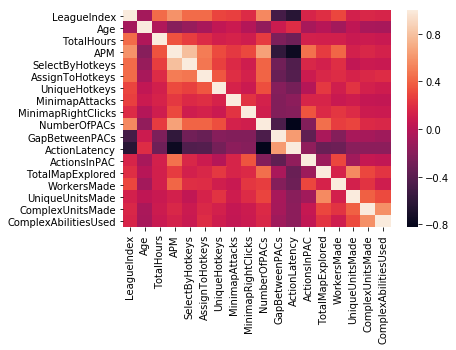

In [5]:
sns.heatmap(df.corr())

In [6]:
f_regression(X_raw, y_raw)

(array([   18.32314493,   639.96388709,  1479.33427993,   620.45193799,
          631.73563285,   252.7305906 ,   210.01578654,    99.56911896,
         1165.24128759,   863.03209272,  1775.86843017,    60.22043204,
          112.71594389,   265.74529265,    44.23207951,    77.76834821,
           64.758307  ]),
 array([  1.92864257e-005,   5.19386982e-127,   6.19917358e-259,
          1.45316708e-123,   1.46745693e-125,   1.71909048e-054,
          6.63594958e-046,   4.68510337e-023,   5.98650755e-213,
          4.79435148e-165,   2.71166321e-299,   1.18984328e-014,
          7.89719040e-026,   4.41298371e-057,   3.51101908e-011,
          2.02492745e-018,   1.25092459e-015]))

In [7]:
Xcov = StandardScaler().fit_transform(df)
Cx = np.cov(Xcov, rowvar=False)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
# Inspecting the eigenvalues and eigenvectors.

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

The percentage of total variance in the dataset explained by each component calculated by hand.
 [ 0.29687973  0.113637    0.0860485   0.06881528  0.00069701  0.00546559
  0.05834512  0.05298814  0.01551593  0.04668214  0.04563246  0.04086192
  0.03798012  0.03453211  0.02125505  0.02189784  0.02346683  0.02929922]


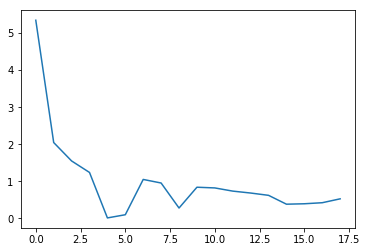

In [8]:
plt.plot(eig_val_cov)
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3)

In [10]:
regr = linear_model.LinearRegression()
pca = PCA(n_components=5)
pca.fit(X_train)
pca_train = pca.transform(X_train)
print(
    'The percentage of total variance explained by each component: ', pca.explained_variance_ratio_
)

The percentage of total variance explained by each component:  [  9.89705330e-01   8.78156480e-03   7.70621947e-04   4.52732518e-04
   1.83025379e-04]


In [11]:
pca_test = pca.transform(X_test)
regr = linear_model.LinearRegression()
regr.fit(pca_train, y_train)
regr.score(pca_test, y_test)

0.47234403896938415

In [12]:
#sc_df = df[['TotalHours', 'Age', 'UniqueHotkeys', 'GapBetweenPACs', 'ActionLatency', 'TotalMapExplored']]
sc_df = df[['LeagueIndex', 'TotalHours', 'APM', 'NumberOfPACs', 'ActionLatency']]

In [13]:
X = sc_df.drop('LeagueIndex', axis=1)
y = sc_df.LeagueIndex

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

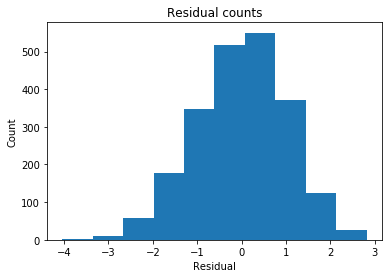

In [15]:
model = regr.fit(X_train, y_train)
predicted = regr.predict(X_train).ravel()
actual = y_train
# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

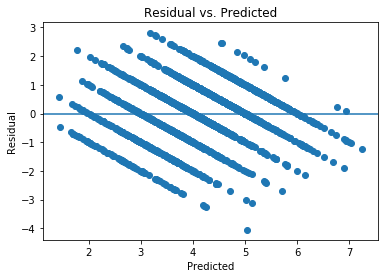

In [16]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [17]:
#linear regression with features
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, y))


Coefficients: 
 [  7.77923282e-04   6.49253979e-03   1.33232920e+02  -2.90946309e-02]

Intercept: 
 4.2986533152

R-squared:
0.479537235517


In [18]:
predictions = regr.predict(X_test)
print(predictions[:5])

print('Training R-squared: ', model.score(X_train, y_train))
print('Test R-squared: ', model.score(X_test, y_test))

[ 3.61653676  5.01627934  5.22342694  5.75908776  3.05667797]
Training R-squared:  0.467658261839
Test R-squared:  0.525927576323


In [19]:
X = df.drop('LeagueIndex', axis=1)
y = df.LeagueIndex

knn = neighbors.KNeighborsRegressor(50)
knn_model = knn.fit(X, y)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.44 (+/- 0.06)
